# **CNN** *Pytorch*

### **Imports...**

In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

/Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/rasmushelviglarsen/miniforge3/envs/IntelligentSystems/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/rasmushelviglarsen/miniforge3/envs/Intelligent

### **GPU/MPS/CPU...**

In [2]:
if torch.cuda.is_available(): 
    device = "cuda"
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"
print(
    f"~~~~~~~~~~~~~~~~~ \n"
    f"Using device: {device} \n"
    f"~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~ 
Using device: mps 
~~~~~~~~~~~~~~~~~


### **CNN...**

In [3]:

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=26): 
       
        super(CNN, self).__init__()

        #1ST CONVOLUTIONAL LAYER
        self.conv1 = nn.Conv2d( 
            in_channels=in_channels,  
            out_channels=64, 
            kernel_size=3, 
            stride=1,  
            padding=1) 
        self.bn1 = nn.BatchNorm2d(64)
        
        #2ND CONVOLUTIONAL LAYER
        self.conv2 = nn.Conv2d(  
            in_channels=64,  
            out_channels=128, 
            kernel_size=3, 
            stride=1, 
            padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        #3RD CONVOLUTIONAL LAYER
        self.conv3 = nn.Conv2d(
            in_channels = 128,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        
        #POOLING LAYER
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #DROPOUT LAYER (FOR REGULARIZATION)
        self.drop_conv = nn.Dropout2d(p=0.2)
        self.drop_fc = nn.Dropout(p=0.5) 
        
        #FULLY CONNECTED LAYER
        self.adap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = self.pool(x) 
        x = self.drop_conv(x)          

        x = F.relu(self.bn2(self.conv2(x)))  
        x = self.pool(x)
        x = self.drop_conv(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.drop_conv(x)

        x = self.adap(x)
        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)       
        x = self.fc2(x)            

        return x
print(
    f"~~~~~~~~~ \n"
    f"CNN ready! \n"
    f"~~~~~~~~~")

~~~~~~~~~ 
CNN ready! 
~~~~~~~~~


### **Hyperparamethers...**

In [4]:
num_classes = 26 
learning_rate = 0.005
batch_size = 128
num_epochs = 100
weight_decay = 0

### **Data loading, preprocessing and transforming...**

In [5]:
def emnist_rotation(img):
    img = img.rotate(-90, expand = True)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

def train_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((32,32),antialias=True), 
    transforms.Lambda(emnist_rotation),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1), shear = 3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

def test_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32),antialias=True),
    transforms.Lambda(emnist_rotation),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

train_dataset = datasets.EMNIST(root='emnist-letters-train',split='letters', train=True, download=True, transform=train_transform(), target_transform=lambda y: y-1)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.EMNIST(root='emnist-letters-test', split='letters', train=False, download=True, transform=test_transform(), target_transform=lambda y: y-1)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### **Initialize network with loss and optimizer...**

In [6]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing= 0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

### **Train and evaluate...**

In [8]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # TRAINING 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        scores = model(data) # Forward
        loss = criterion(scores, targets)

        loss.backward() # Backward
        optimizer.step()

        batch_size = targets.size(0)
        train_loss += loss.item() * batch_size
        
        _, preds = scores.max(1)
        train_correct += (preds == targets).sum().item()
        train_total += batch_size
    
    train_loss /= train_total
    train_acc = 100.0 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # EVALUATION 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            scores = model(x)
            
            loss = criterion(scores, y)
            batch_size = y.size(0)
            test_loss += loss.item() * batch_size

            _, predictions = scores.max(1) 
            test_correct += (predictions == y).sum().item() 
            test_total += batch_size

    test_loss /= test_total
    test_acc = float(test_correct) / float(test_total) * 100.0
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
        
    print(
        f" \n "
        f"|~|TRAINING:|~| Accuracy: {train_acc:.2f}, Loss: {train_loss:.4f}. \n "
        f"|~|TESTING:|~| Accuracy: {test_acc:.2f}, Loss: {test_loss:.4f}. \n " 
        f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
        )
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # SCHEDULER 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    scheduler.step()

    print()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# FINAL METRICS 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
final_train_loss = train_losses[-1]
final_train_acc = train_accuracies[-1]
final_test_loss = test_losses[-1]
final_test_acc = test_accuracies[-1]

print("===== Training Complete =====")
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
    

Epoch [1/100]
Learning rate: 0.005000


100%|██████████| 975/975 [00:38<00:00, 25.53it/s]


 
 |~|TRAINING:|~| Accuracy: 53.04, Loss: 1.4729. 
 |~|TESTING:|~| Accuracy: 87.08, Loss: 0.4149. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [2/100]
Learning rate: 0.004999


100%|██████████| 975/975 [00:37<00:00, 26.11it/s]


 
 |~|TRAINING:|~| Accuracy: 79.49, Loss: 0.6517. 
 |~|TESTING:|~| Accuracy: 91.42, Loss: 0.2657. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [3/100]
Learning rate: 0.004995


100%|██████████| 975/975 [00:40<00:00, 23.88it/s]


 
 |~|TRAINING:|~| Accuracy: 83.93, Loss: 0.5120. 
 |~|TESTING:|~| Accuracy: 92.79, Loss: 0.2248. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [4/100]
Learning rate: 0.004989


100%|██████████| 975/975 [00:52<00:00, 18.57it/s]


 
 |~|TRAINING:|~| Accuracy: 85.83, Loss: 0.4536. 
 |~|TESTING:|~| Accuracy: 93.02, Loss: 0.2138. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [5/100]
Learning rate: 0.004980


100%|██████████| 975/975 [00:44<00:00, 21.75it/s]


 
 |~|TRAINING:|~| Accuracy: 86.94, Loss: 0.4158. 
 |~|TESTING:|~| Accuracy: 93.30, Loss: 0.1971. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [6/100]
Learning rate: 0.004969


100%|██████████| 975/975 [00:37<00:00, 25.81it/s]


 
 |~|TRAINING:|~| Accuracy: 87.80, Loss: 0.3890. 
 |~|TESTING:|~| Accuracy: 92.92, Loss: 0.2031. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [7/100]
Learning rate: 0.004956


100%|██████████| 975/975 [00:46<00:00, 21.09it/s]


 
 |~|TRAINING:|~| Accuracy: 88.39, Loss: 0.3710. 
 |~|TESTING:|~| Accuracy: 93.62, Loss: 0.1898. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [8/100]
Learning rate: 0.004940


100%|██████████| 975/975 [00:47<00:00, 20.68it/s]


 
 |~|TRAINING:|~| Accuracy: 88.59, Loss: 0.3621. 
 |~|TESTING:|~| Accuracy: 93.87, Loss: 0.1820. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [9/100]
Learning rate: 0.004921


100%|██████████| 975/975 [00:38<00:00, 25.62it/s]


 
 |~|TRAINING:|~| Accuracy: 88.97, Loss: 0.3472. 
 |~|TESTING:|~| Accuracy: 94.03, Loss: 0.1817. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [10/100]
Learning rate: 0.004901


100%|██████████| 975/975 [00:47<00:00, 20.68it/s]


 
 |~|TRAINING:|~| Accuracy: 89.23, Loss: 0.3401. 
 |~|TESTING:|~| Accuracy: 93.87, Loss: 0.1859. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [11/100]
Learning rate: 0.004878


100%|██████████| 975/975 [00:59<00:00, 16.28it/s]


 
 |~|TRAINING:|~| Accuracy: 89.50, Loss: 0.3295. 
 |~|TESTING:|~| Accuracy: 94.10, Loss: 0.1806. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [12/100]
Learning rate: 0.004852


100%|██████████| 975/975 [00:36<00:00, 26.44it/s]


 
 |~|TRAINING:|~| Accuracy: 89.56, Loss: 0.3286. 
 |~|TESTING:|~| Accuracy: 93.55, Loss: 0.1840. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [13/100]
Learning rate: 0.004824


100%|██████████| 975/975 [00:33<00:00, 28.74it/s]


 
 |~|TRAINING:|~| Accuracy: 89.87, Loss: 0.3192. 
 |~|TESTING:|~| Accuracy: 94.07, Loss: 0.1811. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [14/100]
Learning rate: 0.004794


100%|██████████| 975/975 [00:34<00:00, 28.02it/s]


 
 |~|TRAINING:|~| Accuracy: 90.08, Loss: 0.3130. 
 |~|TESTING:|~| Accuracy: 94.19, Loss: 0.1798. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [15/100]
Learning rate: 0.004762


100%|██████████| 975/975 [00:40<00:00, 24.27it/s]


 
 |~|TRAINING:|~| Accuracy: 90.25, Loss: 0.3062. 
 |~|TESTING:|~| Accuracy: 94.11, Loss: 0.1790. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [16/100]
Learning rate: 0.004728


100%|██████████| 975/975 [00:35<00:00, 27.38it/s]


 
 |~|TRAINING:|~| Accuracy: 90.36, Loss: 0.3007. 
 |~|TESTING:|~| Accuracy: 94.26, Loss: 0.1783. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [17/100]
Learning rate: 0.004691


100%|██████████| 975/975 [00:35<00:00, 27.31it/s]


 
 |~|TRAINING:|~| Accuracy: 90.60, Loss: 0.2965. 
 |~|TESTING:|~| Accuracy: 94.40, Loss: 0.1692. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [18/100]
Learning rate: 0.004652


100%|██████████| 975/975 [00:37<00:00, 25.71it/s]


 
 |~|TRAINING:|~| Accuracy: 90.88, Loss: 0.2886. 
 |~|TESTING:|~| Accuracy: 93.98, Loss: 0.1728. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [19/100]
Learning rate: 0.004611


100%|██████████| 975/975 [00:35<00:00, 27.18it/s]


 
 |~|TRAINING:|~| Accuracy: 90.92, Loss: 0.2836. 
 |~|TESTING:|~| Accuracy: 94.30, Loss: 0.1692. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [20/100]
Learning rate: 0.004568


100%|██████████| 975/975 [00:33<00:00, 28.91it/s]


 
 |~|TRAINING:|~| Accuracy: 91.00, Loss: 0.2815. 
 |~|TESTING:|~| Accuracy: 94.37, Loss: 0.1720. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [21/100]
Learning rate: 0.004523


100%|██████████| 975/975 [00:33<00:00, 29.03it/s]


 
 |~|TRAINING:|~| Accuracy: 91.06, Loss: 0.2778. 
 |~|TESTING:|~| Accuracy: 94.50, Loss: 0.1654. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [22/100]
Learning rate: 0.004475


100%|██████████| 975/975 [00:34<00:00, 28.40it/s]


 
 |~|TRAINING:|~| Accuracy: 91.28, Loss: 0.2718. 
 |~|TESTING:|~| Accuracy: 94.53, Loss: 0.1658. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [23/100]
Learning rate: 0.004426


100%|██████████| 975/975 [00:33<00:00, 29.01it/s]


 
 |~|TRAINING:|~| Accuracy: 91.33, Loss: 0.2696. 
 |~|TESTING:|~| Accuracy: 94.61, Loss: 0.1654. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [24/100]
Learning rate: 0.004375


100%|██████████| 975/975 [00:35<00:00, 27.15it/s]


 
 |~|TRAINING:|~| Accuracy: 91.44, Loss: 0.2677. 
 |~|TESTING:|~| Accuracy: 94.47, Loss: 0.1745. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [25/100]
Learning rate: 0.004322


100%|██████████| 975/975 [00:35<00:00, 27.39it/s]


 
 |~|TRAINING:|~| Accuracy: 91.55, Loss: 0.2637. 
 |~|TESTING:|~| Accuracy: 94.58, Loss: 0.1655. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [26/100]
Learning rate: 0.004268


100%|██████████| 975/975 [00:35<00:00, 27.29it/s]


 
 |~|TRAINING:|~| Accuracy: 91.61, Loss: 0.2604. 
 |~|TESTING:|~| Accuracy: 94.52, Loss: 0.1696. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [27/100]
Learning rate: 0.004211


100%|██████████| 975/975 [00:36<00:00, 26.92it/s]


 
 |~|TRAINING:|~| Accuracy: 91.65, Loss: 0.2588. 
 |~|TESTING:|~| Accuracy: 94.57, Loss: 0.1698. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [28/100]
Learning rate: 0.004153


100%|██████████| 975/975 [00:35<00:00, 27.59it/s]


 
 |~|TRAINING:|~| Accuracy: 91.73, Loss: 0.2595. 
 |~|TESTING:|~| Accuracy: 94.60, Loss: 0.1717. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [29/100]
Learning rate: 0.004094


100%|██████████| 975/975 [00:37<00:00, 26.35it/s]


 
 |~|TRAINING:|~| Accuracy: 91.78, Loss: 0.2552. 
 |~|TESTING:|~| Accuracy: 94.59, Loss: 0.1636. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [30/100]
Learning rate: 0.004032


100%|██████████| 975/975 [00:34<00:00, 28.44it/s]


 
 |~|TRAINING:|~| Accuracy: 91.83, Loss: 0.2543. 
 |~|TESTING:|~| Accuracy: 94.70, Loss: 0.1639. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [31/100]
Learning rate: 0.003969


100%|██████████| 975/975 [00:35<00:00, 27.25it/s]


 
 |~|TRAINING:|~| Accuracy: 91.86, Loss: 0.2532. 
 |~|TESTING:|~| Accuracy: 94.76, Loss: 0.1620. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [32/100]
Learning rate: 0.003905


100%|██████████| 975/975 [00:34<00:00, 28.57it/s]


 
 |~|TRAINING:|~| Accuracy: 91.98, Loss: 0.2480. 
 |~|TESTING:|~| Accuracy: 94.76, Loss: 0.1623. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [33/100]
Learning rate: 0.003840


100%|██████████| 975/975 [00:37<00:00, 25.88it/s]


 
 |~|TRAINING:|~| Accuracy: 92.00, Loss: 0.2478. 
 |~|TESTING:|~| Accuracy: 94.88, Loss: 0.1620. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [34/100]
Learning rate: 0.003773


100%|██████████| 975/975 [00:34<00:00, 28.51it/s]


 
 |~|TRAINING:|~| Accuracy: 92.13, Loss: 0.2422. 
 |~|TESTING:|~| Accuracy: 94.88, Loss: 0.1620. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [35/100]
Learning rate: 0.003704


100%|██████████| 975/975 [00:34<00:00, 28.33it/s]


 
 |~|TRAINING:|~| Accuracy: 92.18, Loss: 0.2439. 
 |~|TESTING:|~| Accuracy: 94.67, Loss: 0.1652. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [36/100]
Learning rate: 0.003635


100%|██████████| 975/975 [00:34<00:00, 28.28it/s]


 
 |~|TRAINING:|~| Accuracy: 92.21, Loss: 0.2421. 
 |~|TESTING:|~| Accuracy: 94.83, Loss: 0.1592. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [37/100]
Learning rate: 0.003564


100%|██████████| 975/975 [00:34<00:00, 28.09it/s]


 
 |~|TRAINING:|~| Accuracy: 92.23, Loss: 0.2411. 
 |~|TESTING:|~| Accuracy: 94.72, Loss: 0.1620. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [38/100]
Learning rate: 0.003493


100%|██████████| 975/975 [00:34<00:00, 28.61it/s]


 
 |~|TRAINING:|~| Accuracy: 92.25, Loss: 0.2406. 
 |~|TESTING:|~| Accuracy: 94.89, Loss: 0.1589. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [39/100]
Learning rate: 0.003420


100%|██████████| 975/975 [00:34<00:00, 28.30it/s]


 
 |~|TRAINING:|~| Accuracy: 92.33, Loss: 0.2372. 
 |~|TESTING:|~| Accuracy: 94.98, Loss: 0.1634. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [40/100]
Learning rate: 0.003347


100%|██████████| 975/975 [00:34<00:00, 28.64it/s]


 
 |~|TRAINING:|~| Accuracy: 92.42, Loss: 0.2338. 
 |~|TESTING:|~| Accuracy: 94.89, Loss: 0.1618. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [41/100]
Learning rate: 0.003273


100%|██████████| 975/975 [00:34<00:00, 28.50it/s]


 
 |~|TRAINING:|~| Accuracy: 92.37, Loss: 0.2361. 
 |~|TESTING:|~| Accuracy: 94.87, Loss: 0.1602. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [42/100]
Learning rate: 0.003197


100%|██████████| 975/975 [00:33<00:00, 28.77it/s]


 
 |~|TRAINING:|~| Accuracy: 92.50, Loss: 0.2316. 
 |~|TESTING:|~| Accuracy: 94.69, Loss: 0.1590. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [43/100]
Learning rate: 0.003122


100%|██████████| 975/975 [00:34<00:00, 28.28it/s]


 
 |~|TRAINING:|~| Accuracy: 92.51, Loss: 0.2296. 
 |~|TESTING:|~| Accuracy: 94.96, Loss: 0.1621. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [44/100]
Learning rate: 0.003045


100%|██████████| 975/975 [00:34<00:00, 28.13it/s]


 
 |~|TRAINING:|~| Accuracy: 92.53, Loss: 0.2306. 
 |~|TESTING:|~| Accuracy: 94.64, Loss: 0.1592. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [45/100]
Learning rate: 0.002968


100%|██████████| 975/975 [00:33<00:00, 28.73it/s]


 
 |~|TRAINING:|~| Accuracy: 92.57, Loss: 0.2292. 
 |~|TESTING:|~| Accuracy: 94.90, Loss: 0.1622. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [46/100]
Learning rate: 0.002891


100%|██████████| 975/975 [00:37<00:00, 26.06it/s]


 
 |~|TRAINING:|~| Accuracy: 92.65, Loss: 0.2231. 
 |~|TESTING:|~| Accuracy: 95.11, Loss: 0.1617. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [47/100]
Learning rate: 0.002813


100%|██████████| 975/975 [00:33<00:00, 28.96it/s]


 
 |~|TRAINING:|~| Accuracy: 92.64, Loss: 0.2272. 
 |~|TESTING:|~| Accuracy: 94.75, Loss: 0.1612. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [48/100]
Learning rate: 0.002735


100%|██████████| 975/975 [00:34<00:00, 28.10it/s]


 
 |~|TRAINING:|~| Accuracy: 92.71, Loss: 0.2235. 
 |~|TESTING:|~| Accuracy: 94.91, Loss: 0.1593. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [49/100]
Learning rate: 0.002657


100%|██████████| 975/975 [00:33<00:00, 28.77it/s]


 
 |~|TRAINING:|~| Accuracy: 92.77, Loss: 0.2230. 
 |~|TESTING:|~| Accuracy: 95.07, Loss: 0.1581. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [50/100]
Learning rate: 0.002579


100%|██████████| 975/975 [00:33<00:00, 28.88it/s]


 
 |~|TRAINING:|~| Accuracy: 92.77, Loss: 0.2225. 
 |~|TESTING:|~| Accuracy: 95.01, Loss: 0.1567. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [51/100]
Learning rate: 0.002500


100%|██████████| 975/975 [00:34<00:00, 28.63it/s]


 
 |~|TRAINING:|~| Accuracy: 92.90, Loss: 0.2189. 
 |~|TESTING:|~| Accuracy: 94.92, Loss: 0.1592. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [52/100]
Learning rate: 0.002421


100%|██████████| 975/975 [00:33<00:00, 28.93it/s]


 
 |~|TRAINING:|~| Accuracy: 92.94, Loss: 0.2171. 
 |~|TESTING:|~| Accuracy: 94.99, Loss: 0.1595. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [53/100]
Learning rate: 0.002343


100%|██████████| 975/975 [00:35<00:00, 27.46it/s]


 
 |~|TRAINING:|~| Accuracy: 92.91, Loss: 0.2200. 
 |~|TESTING:|~| Accuracy: 94.94, Loss: 0.1598. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [54/100]
Learning rate: 0.002265


100%|██████████| 975/975 [00:39<00:00, 24.72it/s]


 
 |~|TRAINING:|~| Accuracy: 92.98, Loss: 0.2144. 
 |~|TESTING:|~| Accuracy: 94.89, Loss: 0.1582. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [55/100]
Learning rate: 0.002187


100%|██████████| 975/975 [00:33<00:00, 28.89it/s]


 
 |~|TRAINING:|~| Accuracy: 93.07, Loss: 0.2116. 
 |~|TESTING:|~| Accuracy: 95.15, Loss: 0.1562. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [56/100]
Learning rate: 0.002109


100%|██████████| 975/975 [00:34<00:00, 28.23it/s]


 
 |~|TRAINING:|~| Accuracy: 93.08, Loss: 0.2108. 
 |~|TESTING:|~| Accuracy: 95.10, Loss: 0.1564. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [57/100]
Learning rate: 0.002032


100%|██████████| 975/975 [00:34<00:00, 28.56it/s]


 
 |~|TRAINING:|~| Accuracy: 93.00, Loss: 0.2127. 
 |~|TESTING:|~| Accuracy: 95.01, Loss: 0.1576. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [58/100]
Learning rate: 0.001955


100%|██████████| 975/975 [00:34<00:00, 28.33it/s]


 
 |~|TRAINING:|~| Accuracy: 93.11, Loss: 0.2102. 
 |~|TESTING:|~| Accuracy: 95.06, Loss: 0.1547. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [59/100]
Learning rate: 0.001878


100%|██████████| 975/975 [00:35<00:00, 27.68it/s]


 
 |~|TRAINING:|~| Accuracy: 93.07, Loss: 0.2096. 
 |~|TESTING:|~| Accuracy: 95.10, Loss: 0.1553. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [60/100]
Learning rate: 0.001803


100%|██████████| 975/975 [00:33<00:00, 28.75it/s]


 
 |~|TRAINING:|~| Accuracy: 93.20, Loss: 0.2084. 
 |~|TESTING:|~| Accuracy: 95.01, Loss: 0.1596. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [61/100]
Learning rate: 0.001727


100%|██████████| 975/975 [00:34<00:00, 28.56it/s]


 
 |~|TRAINING:|~| Accuracy: 93.24, Loss: 0.2081. 
 |~|TESTING:|~| Accuracy: 95.04, Loss: 0.1591. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [62/100]
Learning rate: 0.001653


100%|██████████| 975/975 [00:34<00:00, 28.58it/s]


 
 |~|TRAINING:|~| Accuracy: 93.23, Loss: 0.2061. 
 |~|TESTING:|~| Accuracy: 95.07, Loss: 0.1545. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [63/100]
Learning rate: 0.001580


100%|██████████| 975/975 [00:33<00:00, 28.86it/s]


 
 |~|TRAINING:|~| Accuracy: 93.29, Loss: 0.2032. 
 |~|TESTING:|~| Accuracy: 95.08, Loss: 0.1538. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [64/100]
Learning rate: 0.001507


100%|██████████| 975/975 [00:34<00:00, 28.13it/s]


 
 |~|TRAINING:|~| Accuracy: 93.41, Loss: 0.2021. 
 |~|TESTING:|~| Accuracy: 95.08, Loss: 0.1546. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [65/100]
Learning rate: 0.001436


100%|██████████| 975/975 [00:35<00:00, 27.39it/s]


 
 |~|TRAINING:|~| Accuracy: 93.34, Loss: 0.2024. 
 |~|TESTING:|~| Accuracy: 95.06, Loss: 0.1541. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [66/100]
Learning rate: 0.001365


100%|██████████| 975/975 [00:34<00:00, 28.36it/s]


 
 |~|TRAINING:|~| Accuracy: 93.37, Loss: 0.1993. 
 |~|TESTING:|~| Accuracy: 95.14, Loss: 0.1519. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [67/100]
Learning rate: 0.001296


100%|██████████| 975/975 [00:34<00:00, 28.16it/s]


 
 |~|TRAINING:|~| Accuracy: 93.36, Loss: 0.2002. 
 |~|TESTING:|~| Accuracy: 95.01, Loss: 0.1541. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [68/100]
Learning rate: 0.001227


100%|██████████| 975/975 [00:37<00:00, 26.07it/s]


 
 |~|TRAINING:|~| Accuracy: 93.41, Loss: 0.1989. 
 |~|TESTING:|~| Accuracy: 95.22, Loss: 0.1541. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [69/100]
Learning rate: 0.001160


100%|██████████| 975/975 [00:37<00:00, 25.93it/s]


 
 |~|TRAINING:|~| Accuracy: 93.45, Loss: 0.1989. 
 |~|TESTING:|~| Accuracy: 95.25, Loss: 0.1538. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [70/100]
Learning rate: 0.001095


100%|██████████| 975/975 [00:34<00:00, 27.90it/s]


 
 |~|TRAINING:|~| Accuracy: 93.51, Loss: 0.1976. 
 |~|TESTING:|~| Accuracy: 95.17, Loss: 0.1523. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [71/100]
Learning rate: 0.001031


100%|██████████| 975/975 [00:34<00:00, 28.67it/s]


 
 |~|TRAINING:|~| Accuracy: 93.42, Loss: 0.1973. 
 |~|TESTING:|~| Accuracy: 95.23, Loss: 0.1536. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [72/100]
Learning rate: 0.000968


100%|██████████| 975/975 [00:34<00:00, 28.17it/s]


 
 |~|TRAINING:|~| Accuracy: 93.49, Loss: 0.1969. 
 |~|TESTING:|~| Accuracy: 95.24, Loss: 0.1518. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [73/100]
Learning rate: 0.000906


100%|██████████| 975/975 [00:34<00:00, 28.47it/s]


 
 |~|TRAINING:|~| Accuracy: 93.56, Loss: 0.1935. 
 |~|TESTING:|~| Accuracy: 95.24, Loss: 0.1535. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [74/100]
Learning rate: 0.000847


100%|██████████| 975/975 [00:33<00:00, 28.74it/s]


 
 |~|TRAINING:|~| Accuracy: 93.57, Loss: 0.1949. 
 |~|TESTING:|~| Accuracy: 95.10, Loss: 0.1533. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [75/100]
Learning rate: 0.000789


100%|██████████| 975/975 [00:34<00:00, 28.46it/s]


 
 |~|TRAINING:|~| Accuracy: 93.60, Loss: 0.1941. 
 |~|TESTING:|~| Accuracy: 95.12, Loss: 0.1541. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [76/100]
Learning rate: 0.000732


100%|██████████| 975/975 [00:34<00:00, 28.65it/s]


 
 |~|TRAINING:|~| Accuracy: 93.55, Loss: 0.1940. 
 |~|TESTING:|~| Accuracy: 95.19, Loss: 0.1518. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [77/100]
Learning rate: 0.000678


100%|██████████| 975/975 [00:34<00:00, 28.41it/s]


 
 |~|TRAINING:|~| Accuracy: 93.67, Loss: 0.1918. 
 |~|TESTING:|~| Accuracy: 95.28, Loss: 0.1509. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [78/100]
Learning rate: 0.000625


100%|██████████| 975/975 [00:34<00:00, 28.50it/s]


 
 |~|TRAINING:|~| Accuracy: 93.57, Loss: 0.1934. 
 |~|TESTING:|~| Accuracy: 95.25, Loss: 0.1508. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [79/100]
Learning rate: 0.000574


100%|██████████| 975/975 [00:34<00:00, 28.65it/s]


 
 |~|TRAINING:|~| Accuracy: 93.63, Loss: 0.1911. 
 |~|TESTING:|~| Accuracy: 95.25, Loss: 0.1505. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [80/100]
Learning rate: 0.000525


100%|██████████| 975/975 [00:34<00:00, 27.86it/s]


 
 |~|TRAINING:|~| Accuracy: 93.70, Loss: 0.1893. 
 |~|TESTING:|~| Accuracy: 95.29, Loss: 0.1516. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [81/100]
Learning rate: 0.000477


100%|██████████| 975/975 [00:34<00:00, 28.50it/s]


 
 |~|TRAINING:|~| Accuracy: 93.64, Loss: 0.1915. 
 |~|TESTING:|~| Accuracy: 95.28, Loss: 0.1513. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [82/100]
Learning rate: 0.000432


100%|██████████| 975/975 [00:43<00:00, 22.20it/s]


 
 |~|TRAINING:|~| Accuracy: 93.69, Loss: 0.1918. 
 |~|TESTING:|~| Accuracy: 95.28, Loss: 0.1518. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [83/100]
Learning rate: 0.000389


100%|██████████| 975/975 [00:34<00:00, 28.31it/s]


 
 |~|TRAINING:|~| Accuracy: 93.74, Loss: 0.1892. 
 |~|TESTING:|~| Accuracy: 95.26, Loss: 0.1505. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [84/100]
Learning rate: 0.000348


100%|██████████| 975/975 [00:33<00:00, 28.71it/s]


 
 |~|TRAINING:|~| Accuracy: 93.72, Loss: 0.1875. 
 |~|TESTING:|~| Accuracy: 95.21, Loss: 0.1512. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [85/100]
Learning rate: 0.000309


100%|██████████| 975/975 [00:34<00:00, 28.44it/s]


 
 |~|TRAINING:|~| Accuracy: 93.80, Loss: 0.1882. 
 |~|TESTING:|~| Accuracy: 95.27, Loss: 0.1506. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [86/100]
Learning rate: 0.000272


100%|██████████| 975/975 [00:34<00:00, 28.21it/s]


 
 |~|TRAINING:|~| Accuracy: 93.80, Loss: 0.1863. 
 |~|TESTING:|~| Accuracy: 95.29, Loss: 0.1509. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [87/100]
Learning rate: 0.000238


100%|██████████| 975/975 [00:34<00:00, 28.49it/s]


 
 |~|TRAINING:|~| Accuracy: 93.78, Loss: 0.1882. 
 |~|TESTING:|~| Accuracy: 95.20, Loss: 0.1509. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [88/100]
Learning rate: 0.000206


100%|██████████| 975/975 [00:35<00:00, 27.38it/s]


 
 |~|TRAINING:|~| Accuracy: 93.86, Loss: 0.1872. 
 |~|TESTING:|~| Accuracy: 95.29, Loss: 0.1501. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [89/100]
Learning rate: 0.000176


100%|██████████| 975/975 [00:34<00:00, 28.13it/s]


 
 |~|TRAINING:|~| Accuracy: 93.81, Loss: 0.1861. 
 |~|TESTING:|~| Accuracy: 95.30, Loss: 0.1507. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [90/100]
Learning rate: 0.000148


100%|██████████| 975/975 [00:35<00:00, 27.64it/s]


 
 |~|TRAINING:|~| Accuracy: 93.74, Loss: 0.1877. 
 |~|TESTING:|~| Accuracy: 95.29, Loss: 0.1502. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [91/100]
Learning rate: 0.000122


100%|██████████| 975/975 [00:34<00:00, 28.37it/s]


 
 |~|TRAINING:|~| Accuracy: 93.87, Loss: 0.1868. 
 |~|TESTING:|~| Accuracy: 95.29, Loss: 0.1504. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [92/100]
Learning rate: 0.000099


100%|██████████| 975/975 [00:39<00:00, 24.70it/s]


 
 |~|TRAINING:|~| Accuracy: 93.85, Loss: 0.1858. 
 |~|TESTING:|~| Accuracy: 95.30, Loss: 0.1504. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [93/100]
Learning rate: 0.000079


100%|██████████| 975/975 [00:38<00:00, 25.64it/s]


 
 |~|TRAINING:|~| Accuracy: 93.89, Loss: 0.1854. 
 |~|TESTING:|~| Accuracy: 95.34, Loss: 0.1500. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [94/100]
Learning rate: 0.000060


100%|██████████| 975/975 [00:34<00:00, 28.44it/s]


 
 |~|TRAINING:|~| Accuracy: 93.87, Loss: 0.1845. 
 |~|TESTING:|~| Accuracy: 95.28, Loss: 0.1501. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [95/100]
Learning rate: 0.000044


100%|██████████| 975/975 [00:33<00:00, 28.84it/s]


 
 |~|TRAINING:|~| Accuracy: 93.83, Loss: 0.1852. 
 |~|TESTING:|~| Accuracy: 95.30, Loss: 0.1498. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [96/100]
Learning rate: 0.000031


100%|██████████| 975/975 [00:34<00:00, 28.53it/s]


 
 |~|TRAINING:|~| Accuracy: 93.86, Loss: 0.1838. 
 |~|TESTING:|~| Accuracy: 95.32, Loss: 0.1499. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [97/100]
Learning rate: 0.000020


100%|██████████| 975/975 [00:34<00:00, 28.44it/s]


 
 |~|TRAINING:|~| Accuracy: 93.83, Loss: 0.1865. 
 |~|TESTING:|~| Accuracy: 95.31, Loss: 0.1497. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [98/100]
Learning rate: 0.000011


100%|██████████| 975/975 [00:35<00:00, 27.33it/s]


 
 |~|TRAINING:|~| Accuracy: 93.81, Loss: 0.1854. 
 |~|TESTING:|~| Accuracy: 95.28, Loss: 0.1500. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [99/100]
Learning rate: 0.000005


100%|██████████| 975/975 [00:33<00:00, 28.70it/s]


 
 |~|TRAINING:|~| Accuracy: 93.82, Loss: 0.1866. 
 |~|TESTING:|~| Accuracy: 95.30, Loss: 0.1496. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [100/100]
Learning rate: 0.000001


100%|██████████| 975/975 [00:33<00:00, 28.87it/s]


 
 |~|TRAINING:|~| Accuracy: 93.84, Loss: 0.1848. 
 |~|TESTING:|~| Accuracy: 95.31, Loss: 0.1501. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

===== Training Complete =====
Final Train Loss: 0.1848
Final Train Accuracy: 93.84%
Final Test Loss: 0.1501
Final Test Accuracy: 95.31%


### **Plotting...**

In [9]:
def plot_stats(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc)+1)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

    best_epoch = test_acc.index(max(test_acc))
    best_acc = test_acc[best_epoch]

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ACCURACY PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax1.plot(epochs, train_acc, label="Train Accuracy", color='salmon')
    ax1.plot(epochs, test_acc, label="Test Accuracy", color='sienna')

    ax1.scatter(best_epoch + 1, best_acc, color='indianred', s=50, zorder=5, label=f"Best Test acc ({best_acc:.2f}%) at epoch {best_epoch}")
    ax1.annotate(f'{best_acc:.2f}%',
                 xy=(best_epoch + 1, best_acc),
                 xytext=(best_epoch + 1, best_acc - 6),
                 ha='center', color='indianred',
                 arrowprops=dict(arrowstyle='->', color='black'))
    ax1.set_title('Train vs. test accuracy')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy (%)", color='Sienna')
    ax1.tick_params(axis='y', labelcolor='Sienna')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # LOSS PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax2.plot(epochs, train_loss, label="Train Loss", color='salmon')
    ax2.plot(epochs, test_loss, label="Test Loss", color='sienna')
    ax2.set_title('Train vs. test loss')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss", color='sienna')
    ax2.tick_params(axis='y', labelcolor='sienna')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.5)

    plt.savefig("CNN_results_plot.png")
    plt.tight_layout()
    plt.show()

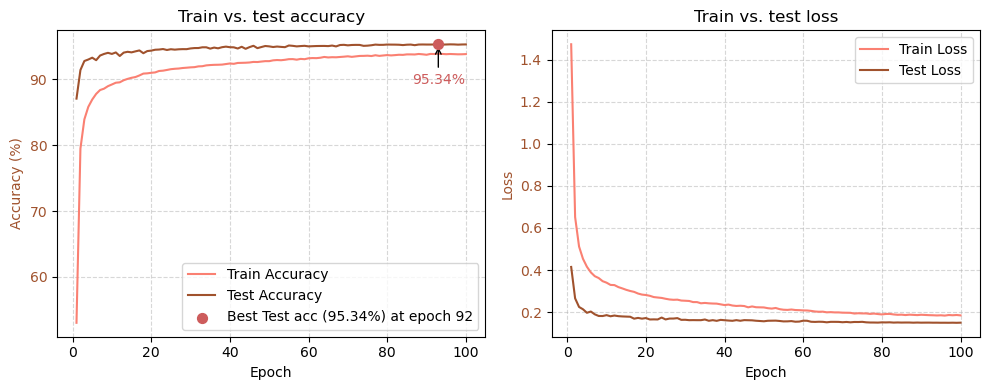

In [10]:
plot_stats(
    train_accuracies, 
    test_accuracies, 
    train_losses, 
    test_losses
)

### **Save results in file...**

In [11]:
results = "CNN_results.txt"
with open(results, "w") as f: 
    f.write("Epoch, Train loss, Train acc, Test loss, Test acc\n")
    for i in range(num_epochs):
        f.write(
            f"{i+1}, "
            f"{train_losses[i]:.4f}, "
            f"{train_accuracies[i]:.2f}%, "
            f"{test_losses[i]:.4f}, "
            f"{test_accuracies[i]:.2f}%\n")
        
    f.write("\n===== Final Metrics =====\n")
    f.write(f"Final Train Loss: {final_train_loss:.4f}\n")
    f.write(f"Final Train Accuracy: {final_train_acc:.2f}%\n")
    f.write(f"Final Test Loss: {final_test_loss:.4f}\n")
    f.write(f"Final Test Accuracy: {final_test_acc:.2f}%\n")

### **Gem efter træning:**

In [12]:
torch.save(model.state_dict(), "my_model_state_dict.pth")

### **Kode til at bruge trænet og gemt model**:

Skal indsættes i toppen af "train and evaluate" kodedelen

In [ ]:
model = CNN(nn.Module)           # samme definition som under træning!
model.load_state_dict(torch.load("my_model_state_dict.pth", weights_only=True))
model.to(device)
model.eval()

# nu kør test
with torch.no_grad():
    # ... inference kode ...